# Deep Learning 2026: Project Overview

This notebook implements the LXMERT architecture for Image-Text Matching (ITM) on the Flickr30k dataset.

### Architecture Selection
**Chosen Architecture**: [Multimodal Transformer]: LXMERT: Learning Cross-Modality Encoder Representations from Transformers (Tan & Bansal, 2019).

---

## Literature Review vs Methodology: Comparison with Original Paper

Below is a detailed comparison between the original LXMERT paper and this "From Scratch" implementation. This section highlights the authorized simplifications.

### 1. Data Preparation (Inputs)

#### A. Visual Part (Images)
This is where the major technical simplification lies.

| Feature | Original LXMERT Paper | Our Implementation | Verdict |
| :--- | :--- | :--- | :--- |
| **Backbone** | Faster R-CNN with ResNet-101 | Faster R-CNN with ResNet-50 FPN | Different |
| **Weights Source** | Trained on Visual Genome (rich attributes) | Trained on COCO (standard detection) | Different |
| **Feature Type** | "Bottom-Up Attention" features | Standard ROI Pooling features | Simplification |
| **Dimension** | 2048 | 1024 | Simplification |
| **Num Boxes** | 36 (fixed) | 36 (fixed) | Identical |

**Analysis**: The paper uses much "smarter" and heavier visual features (ResNet-101 vs ResNet-50). Visual Genome contains classes like "red", "sitting", "tall", whereas COCO has "cat", "dog". Our model sees fewer fine-grained details than the original.

#### B. Textual Part (Language)

| Feature | Original LXMERT Paper | Our Implementation | Verdict |
| :--- | :--- | :--- | :--- |
| **Tokenizer** | BertTokenizer (WordPiece) | BertTokenizer (WordPiece) | Identical |
| **Vocabulary** | ~30,000 tokens | ~30,000 tokens | Identical |
| **Embeddings** | Initialized with BERT weights | Learned from scratch (Random Init) | Different |

**Analysis**: We use the same tokenization. However, LXMERT benefits from BERT's pre-training on Wikipedia. Our model must learn the meaning of words and images simultaneously, which is significantly harder.

### 2. Model Architecture
Our code respects the topological structure but reduces the capacity.

| Module | Original LXMERT Paper | Our Implementation | Simplification |
| :--- | :--- | :--- | :--- |
| **Language Encoder** | 9 Transformer layers | 2 Layers | Reduced Size |
| **Object Encoder** | 5 Transformer layers | 2 Layers | Reduced Size |
| **Cross-Modality** | 5 Cross-Attention layers | 2 Layers | Reduced Size |
| **Hidden Size** | 768 | 256 | Reduced Size |
| **Cross-Attention** | Text $\leftrightarrow$ Image (Bi-directional) | Text $\leftrightarrow$ Image (Bi-directional) | Identical (Structure) |

**Verdict**: The architecture is structurally faithful. We have all three encoders (Single-Modality x2 + Cross-Modality). The logic is correct, only the depth/width has been reduced for my potatoe GPU.

### 3. Training Objectives (Losses)
The original paper uses "Multi-Task Learning". We focus on a single task.

| Task | Original LXMERT | Our Project | Why? |
| :--- | :--- | :--- | :--- |
| **Masked LM** | Yes | No | Too long to converge from scratch |
| **Masked Object** | Yes | No | Pre-computed features, complex to code |
| **Image-Text Matching** | Yes | Yes | **Main Task** |
| **VQA** | Yes | No | Requires VQA dataset |

**Analysis**: This is the "functional" simplification. LXMERT is pre-trained to understand everything. Our model is trained specifically for matching (ITM).

**Summary**:
"The implemented architecture ('SimpleLXMERT') is topologically faithful to the original paper by Tan & Bansal (2019), maintaining the three-encoder structure (Language, Object, Cross-Modality) and the bi-directional cross-attention mechanism.
However, to adapt to time and hardware constraints (GPU), specific simplifications were made (ResNet-50 vs 101, Reduced Depth/Width, ITM-only Loss)."

## 1. Environment Setup & Imports


In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import random
import numpy as np
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Configuration
Define paths and hyperparameters.
**Optimization**: We lowered the LR to `2e-5` and added a scheduler configuration.


In [2]:
# Paths
CSV_FILE = 'flickr30k_images/results.csv'
FEATURES_DIR = 'flickr30k_features'
IMAGE_DIR = 'flickr30k_images/flickr30k_images'
if not os.path.exists(IMAGE_DIR): IMAGE_DIR = 'flickr30k_images'

# Hyperparameters
BATCH_SIZE = 32
LR = 2e-5
EPOCHS = 10
HIDDEN_DIM = 256
VISUAL_FEAT_DIM = 1024
MAX_LEN = 50

# Dataset Control
DATA_PCT = 1.0


## 3. Dataset Analysis
Before training, let's explore the dataset to understand what we are working with.


In [3]:
# Load raw dataframe for analysis
try:
    df_analysis = pd.read_csv(CSV_FILE, delimiter='|')
    df_analysis.columns = [c.strip() for c in df_analysis.columns]
    print(f'Total Captions: {len(df_analysis)}')
    print(f'Total Unique Images: {df_analysis["image_name"].nunique()}')
except FileNotFoundError:
    print('CSV file not found. Check path.')
    df_analysis = None


Total Captions: 158915
Total Unique Images: 31783


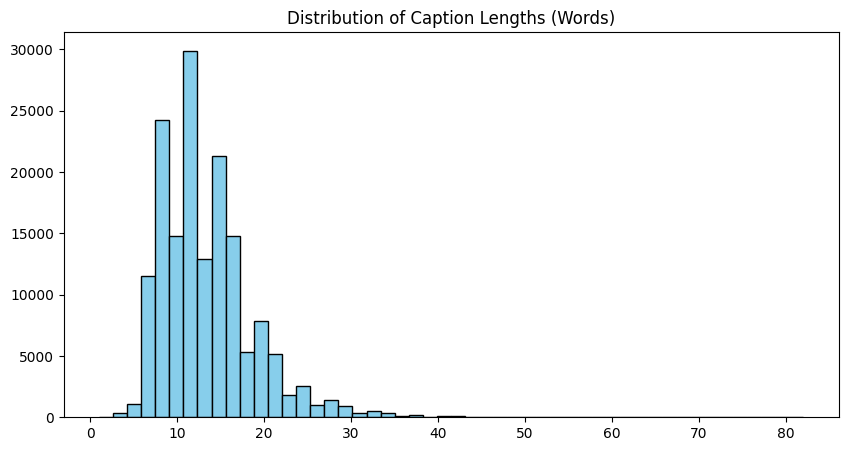

In [4]:
# Analyze Caption Lengths
if df_analysis is not None:
    df_analysis['comment'] = df_analysis['comment'].astype(str)
    seq_lens = [len(x.split()) for x in df_analysis['comment']]
    plt.figure(figsize=(10, 5))
    plt.hist(seq_lens, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Caption Lengths (Words)')
    plt.show()


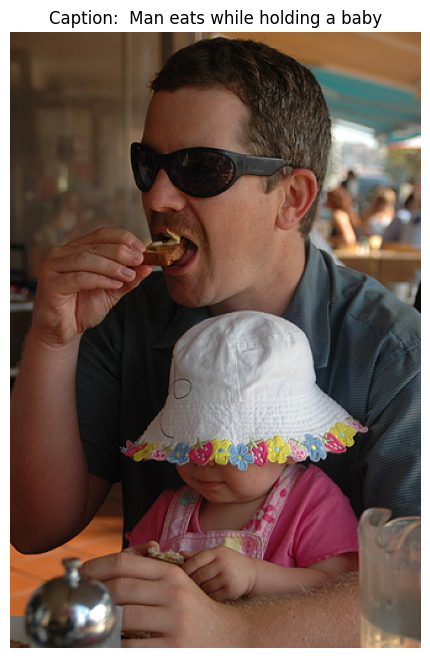

In [5]:
# Visualize Random Sample
def show_random_sample(df, img_dir):
    idx = random.randint(0, len(df)-1)
    row = df.iloc[idx]
    img_name = row['image_name']
    caption = row['comment']
    
    img_path = os.path.join(img_dir, img_name)
    try:
        img = Image.open(img_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Caption: {caption}', fontsize=12, wrap=True)
        plt.show()
    except Exception as e:
        print(f'Could not load image {img_name}: {e}')

if df_analysis is not None:
    show_random_sample(df_analysis, IMAGE_DIR)


## 4. Custom Dataset Class: Preparing ITM Pairs

We implement a custom `torch.utils.data.Dataset` to handle the Image-Text Matching (ITM) task.

### Key Logic: 50/50 Sampling
For the model to learn matching, it needs examples of **matches** (Positive samples) and **mismatches** (Negative samples).
Inside `__getitem__`:
1.  **Positive Sample**: We take the correct image and its caption (Label = 1.0).
2.  **Negative Sample**: With a 50% probability, we swap the caption with a random caption from a different image (Label = 0.0).

This balanced sampling forces the model to actually look at the content matching, rather than memorizing biases.

**Inputs Provided**:
*   `input_ids`, `attention_mask`: For the BERT tokenizer.
*   `visual_feats`: The pre-extracted R-CNN features [36, 1024].
*   `visual_pos`: The bounding box coordinates [36, 4].
*   `label`: 1.0 (Match) or 0.0 (No Match).

In [6]:
class Flickr30kDataset(Dataset):
    def __init__(self, csv_file, features_dir, tokenizer, max_len=128, data_pct=1.0):
        self.data = pd.read_csv(csv_file, delimiter='|')
        self.data.columns = [c.strip() for c in self.data.columns]
        self.data['comment'] = self.data['comment'].astype(str)
        
        if data_pct < 1.0:
            self.data = self.data.sample(frac=data_pct, random_state=42).reset_index(drop=True)
            print(f'Using {len(self.data)} samples ({data_pct*100}%)')
        else:
            print(f'Using full dataset: {len(self.data)} samples')
        
        self.features_dir = features_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['image_name']
        caption = row['comment']
        
        label = 1.0
        if random.random() < 0.5:
            label = 0.0
            rand_idx = random.randint(0, len(self.data) - 1)
            caption = self.data.iloc[rand_idx]['comment']
            
        encoding = self.tokenizer.encode_plus(
            str(caption),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        token_type_ids = encoding['token_type_ids'].squeeze(0)
        
        base_name = img_name.split('.')[0]
        feature_path = os.path.join(self.features_dir, f'{base_name}.pt')
        
        try:
            features = torch.load(feature_path)
            visual_feats = features['visual_feats']
            visual_pos = features['visual_pos']
        except Exception as e:
            visual_feats = torch.zeros(36, VISUAL_FEAT_DIM)
            visual_pos = torch.zeros(36, 4)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'visual_feats': visual_feats,
            'visual_pos': visual_pos,
            'label': torch.tensor(label, dtype=torch.float)
        }


## 5. LXMERT Architecture Details

The **LXMERT (Learning Cross-Modality Encoder Representations from Transformers)** architecture is designed to learn the connections between vision and language. It does this through a specialized structure composed of three main encoders.

### Architecture Schematics

<img src="diagLX.png" width="800" height="1200">


### Component Deep Dive

#### 1. Input & Embeddings (`LXMERTEmbeddings`)
*   **Language Stream**: We use standard BERT inputs.
    *   `Word Embeddings`: Learn the semantic meaning of tokens.
    *   `Position Embeddings`: Learn the order of words (since Transformers are permutation invariant).
    *   `Token Type Embeddings`: Differentiate segments (though here we mostly use segment 0).
*   **Vision Stream**:
    *   `Visual Features`: 1024-dim features extracted from Faster R-CNN (ROI Pooling). We project these to our Hidden Dimension (256).
    *   `Position Features`: 4-dim bounding box coordinates $(x_1, y_1, x_2, y_2)$. We project these to Hidden Dimension (256) and add them to the visual features. This tells the model *where* the object is.
    *   **Normalization**: LayerNorm is applied to both streams to stabilize training.

#### 2. Single-Modality Encoders (`Language Encoder` & `Object Encoder`)
Before merging the information, each modality is processed independently to refine its features.
*   **Language Encoder**: A standard Transformer Encoder (Self-Attention + FFN). It helps the model understand the text context (e.g., "blue" relates to "sky").
*   **Object Encoder**: A standard Transformer Encoder. It allows visual regions to attend to each other (e.g., a "hand" region might attend to a "frisbee" region).

#### 3. Cross-Modality Encoder (`LXMERTXLayer`)
This is the core innovation of LXMERT. It allows the text and image streams to exchange information.
*   **Bidirectional Cross-Attention**:
    1.  **Text attends to Image**: "Which objects in the image are relevant to this word?"
    2.  **Image attends to Text**: "Which words in the sentence describe this object?"
*   These connections are fused using residual connections and LayerNorm, followed by Feed-Forward Networks (FFN).

#### 4. Pooling & Output (`SimpleLXMERT.pooler`)
*   We take the **CLS token** (first token) from the final Cross-Modality Text stream. This token is designed to aggregate the global understanding of the pair.
*   It passes through a `Linear -> Tanh -> Linear` pooler layer.
*   **Final Output**: A single logit representing the probability that the Image and Text match.

### Why this design?
Unlike single-stream models (like VisualBERT) that just concatenate inputs, LXMERT's **two-stream** design ensures that fine-grained details of each modality are preserved in the early stages, while the explicit **cross-attention** layers force the model to perform active reasoning between modes.

In [7]:
# --- Components ---
class LXMERTEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_dim, visual_feat_dim):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.position_embeddings = nn.Embedding(512, hidden_dim)
        self.token_type_embeddings = nn.Embedding(2, hidden_dim)
        self.layer_norm_text = nn.LayerNorm(hidden_dim)
        
        self.visual_proj = nn.Linear(visual_feat_dim, hidden_dim)
        self.pos_proj = nn.Linear(4, hidden_dim)
        self.layer_norm_image = nn.LayerNorm(hidden_dim)
        
    def forward_text(self, input_ids, token_type_ids=None):
        seq_len = input_ids.size(1)
        position_ids = torch.arange(seq_len, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
            
        embeddings = (self.word_embeddings(input_ids) + 
                      self.position_embeddings(position_ids) + 
                      self.token_type_embeddings(token_type_ids))
        return self.layer_norm_text(embeddings)

    def forward_image(self, visual_feats, visual_pos):
        embeddings = self.visual_proj(visual_feats) + self.pos_proj(visual_pos)
        return self.layer_norm_image(embeddings)

class LXMERTXLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads):
        super().__init__()
        self.attn_text_image = nn.MultiheadAttention(hidden_dim, n_heads, batch_first=True)
        self.ln_text1 = nn.LayerNorm(hidden_dim)
        self.ffn_text = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*4), nn.GELU(), nn.Linear(hidden_dim*4, hidden_dim)
        )
        self.ln_text2 = nn.LayerNorm(hidden_dim)
        
        self.attn_image_text = nn.MultiheadAttention(hidden_dim, n_heads, batch_first=True)
        self.ln_image1 = nn.LayerNorm(hidden_dim)
        self.ffn_image = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim*4), nn.GELU(), nn.Linear(hidden_dim*4, hidden_dim)
        )
        self.ln_image2 = nn.LayerNorm(hidden_dim)
        
    def forward(self, text_h, image_h, text_key_padding_mask=None):
        out_text, _ = self.attn_text_image(text_h, image_h, image_h)
        text_h = self.ln_text1(text_h + out_text)
        text_h = self.ln_text2(text_h + self.ffn_text(text_h))
        
        out_image, _ = self.attn_image_text(image_h, text_h, text_h, key_padding_mask=text_key_padding_mask)
        image_h = self.ln_image1(image_h + out_image)
        image_h = self.ln_image2(image_h + self.ffn_image(image_h))
        return text_h, image_h

class SimpleLXMERT(nn.Module):
    def __init__(self, vocab_size=30522, hidden_dim=256, n_layers=2, n_heads=4, visual_feat_dim=1024):
        super().__init__()
        self.embeddings = LXMERTEmbeddings(vocab_size, hidden_dim, visual_feat_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim*4, batch_first=True)
        self.lang_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.obj_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.cross_layers = nn.ModuleList([LXMERTXLayer(hidden_dim, n_heads) for _ in range(n_layers)])
        
        self.pooler = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.Tanh(), nn.Linear(hidden_dim, 1))
        
    def forward(self, input_ids, visual_feats, visual_pos, attention_mask=None, token_type_ids=None):
        text_embeds = self.embeddings.forward_text(input_ids, token_type_ids)
        image_embeds = self.embeddings.forward_image(visual_feats, visual_pos)
        
        text_padding_mask = (attention_mask == 0) if attention_mask is not None else None
        
        text_hidden = self.lang_encoder(text_embeds, src_key_padding_mask=text_padding_mask)
        image_hidden = self.obj_encoder(image_embeds)
        
        for layer in self.cross_layers:
            text_hidden, image_hidden = layer(text_hidden, image_hidden, text_key_padding_mask=text_padding_mask)
            
        return self.pooler(text_hidden[:, 0, :])


## 6. Training Loop

In [8]:
# Initialize Resources
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
full_dataset = Flickr30kDataset(CSV_FILE, FEATURES_DIR, tokenizer, max_len=MAX_LEN, data_pct=DATA_PCT)

# Create Train/Validation Split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Training Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = SimpleLXMERT(hidden_dim=HIDDEN_DIM, visual_feat_dim=VISUAL_FEAT_DIM)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()

# Scheduler Setup
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)

Using full dataset: 158915 samples
Training Set: 127132 samples
Validation Set: 31783 samples


In [9]:
def calculate_metrics(preds, labels):
    """
    Calculate metrics using only PyTorch
    preds: binary predictions (0 or 1)
    labels: binary ground truth (0 or 1)
    """
    tp = (preds * labels).sum().float()
    tn = ((1 - preds) * (1 - labels)).sum().float()
    fp = (preds * (1 - labels)).sum().float()
    fn = ((1 - preds) * labels).sum().float()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return accuracy.item(), precision.item(), recall.item(), f1.item()

def train(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs):
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")
        
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            visual_feats = batch['visual_feats'].to(device)
            visual_pos = batch['visual_pos'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            
            logits = model(input_ids, visual_feats, visual_pos, attention_mask, token_type_ids)
            loss = criterion(logits.squeeze(1), labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
            
        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        # --- Validation Phase ---
        model.eval()
        total_val_loss = 0
        all_preds = []
        all_labels = []
        
        print("Validating...")
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                token_type_ids = batch['token_type_ids'].to(device)
                visual_feats = batch['visual_feats'].to(device)
                visual_pos = batch['visual_pos'].to(device)
                labels = batch['label'].to(device)
                
                logits = model(input_ids, visual_feats, visual_pos, attention_mask, token_type_ids)
                loss = criterion(logits.squeeze(1), labels)
                total_val_loss += loss.item()
                
                # Store predictions for metrics
                preds = (torch.sigmoid(logits.squeeze(1)) > 0.5).float()
                all_preds.append(preds)
                all_labels.append(labels)
        
        avg_val_loss = total_val_loss / len(val_loader)
        
        # Calculate Metrics manually
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        
        val_acc, val_prec, val_rec, val_f1 = calculate_metrics(all_preds, all_labels)
        
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f'Epoch {epoch+1} Results:')
        print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'Val Accuracy: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        print(f'Val Precision: {val_prec:.4f} | Val Recall: {val_rec:.4f}\n')
        
        torch.save(model.state_dict(), f'lxmert_epoch_{epoch+1}.pth')
        
    return history

In [10]:
# Start training
history = train(model, train_loader, val_loader, optimizer, scheduler, criterion, EPOCHS)

Epoch 1/10


Training: 100%|██████████| 3973/3973 [05:24<00:00, 12.25it/s, loss=0.6916]


Validating...


Validation:   0%|          | 0/994 [00:00<?, ?it/s]C:\Users\durak\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Validation: 100%|██████████| 994/994 [00:51<00:00, 19.38it/s]


Epoch 1 Results:
Train Loss: 0.6944 | Val Loss: 0.6954
Val Accuracy: 0.4979 | Val F1: 0.6648
Val Precision: 0.4979 | Val Recall: 1.0000

Epoch 2/10


Training: 100%|██████████| 3973/3973 [04:54<00:00, 13.49it/s, loss=0.5132]


Validating...


Validation: 100%|██████████| 994/994 [00:50<00:00, 19.62it/s]


Epoch 2 Results:
Train Loss: 0.6637 | Val Loss: 0.5920
Val Accuracy: 0.6570 | Val F1: 0.7050
Val Precision: 0.6185 | Val Recall: 0.8196

Epoch 3/10


Training: 100%|██████████| 3973/3973 [04:53<00:00, 13.52it/s, loss=0.6047]


Validating...


Validation: 100%|██████████| 994/994 [00:52<00:00, 19.06it/s]


Epoch 3 Results:
Train Loss: 0.5676 | Val Loss: 0.5383
Val Accuracy: 0.7161 | Val F1: 0.7354
Val Precision: 0.6863 | Val Recall: 0.7921

Epoch 4/10


Training: 100%|██████████| 3973/3973 [04:54<00:00, 13.51it/s, loss=0.4742]


Validating...


Validation: 100%|██████████| 994/994 [00:50<00:00, 19.59it/s]


Epoch 4 Results:
Train Loss: 0.5294 | Val Loss: 0.5107
Val Accuracy: 0.7386 | Val F1: 0.7559
Val Precision: 0.7067 | Val Recall: 0.8124

Epoch 5/10


Training: 100%|██████████| 3973/3973 [04:54<00:00, 13.50it/s, loss=0.3894]


Validating...


Validation: 100%|██████████| 994/994 [00:50<00:00, 19.55it/s]


Epoch 5 Results:
Train Loss: 0.4979 | Val Loss: 0.4919
Val Accuracy: 0.7535 | Val F1: 0.7792
Val Precision: 0.7033 | Val Recall: 0.8734

Epoch 6/10


Training: 100%|██████████| 3973/3973 [04:54<00:00, 13.51it/s, loss=0.4019]


Validating...


Validation: 100%|██████████| 994/994 [00:51<00:00, 19.45it/s]


Epoch 6 Results:
Train Loss: 0.4773 | Val Loss: 0.4613
Val Accuracy: 0.7775 | Val F1: 0.7891
Val Precision: 0.7508 | Val Recall: 0.8315

Epoch 7/10


Training: 100%|██████████| 3973/3973 [04:53<00:00, 13.52it/s, loss=0.2763]


Validating...


Validation: 100%|██████████| 994/994 [00:50<00:00, 19.61it/s]


Epoch 7 Results:
Train Loss: 0.4560 | Val Loss: 0.4402
Val Accuracy: 0.7908 | Val F1: 0.8045
Val Precision: 0.7541 | Val Recall: 0.8620

Epoch 8/10


Training: 100%|██████████| 3973/3973 [04:52<00:00, 13.57it/s, loss=0.3247]


Validating...


Validation: 100%|██████████| 994/994 [00:50<00:00, 19.67it/s]


Epoch 8 Results:
Train Loss: 0.4406 | Val Loss: 0.4419
Val Accuracy: 0.7898 | Val F1: 0.8010
Val Precision: 0.7677 | Val Recall: 0.8373

Epoch 9/10


Training: 100%|██████████| 3973/3973 [04:53<00:00, 13.56it/s, loss=0.2774]


Validating...


Validation: 100%|██████████| 994/994 [00:51<00:00, 19.46it/s]


Epoch 9 Results:
Train Loss: 0.4299 | Val Loss: 0.4275
Val Accuracy: 0.7978 | Val F1: 0.8065
Val Precision: 0.7733 | Val Recall: 0.8427

Epoch 10/10


Training: 100%|██████████| 3973/3973 [04:53<00:00, 13.54it/s, loss=0.2933]


Validating...


Validation: 100%|██████████| 994/994 [00:50<00:00, 19.68it/s]


Epoch 10 Results:
Train Loss: 0.4236 | Val Loss: 0.4230
Val Accuracy: 0.8015 | Val F1: 0.8134
Val Precision: 0.7732 | Val Recall: 0.8579



## 7. Evaluation & Inference

After training, we evaluate the model qualitatively.

*   **Metric**: We look at the **Binary Cross Entropy Loss** during training. A decreasing loss indicates the model is learning to distinguish between matching and non-matching pairs.
*   **Inference**: The `predict_itm` function takes an arbitrary image and a sentence, and outputs a probability score $[0, 1]$.
    *   **Score > 0.5**: The model thinks they match.
    *   **Score < 0.5**: The model thinks they do not match.

We will visualize a random example from the validation set to see the model's prediction.

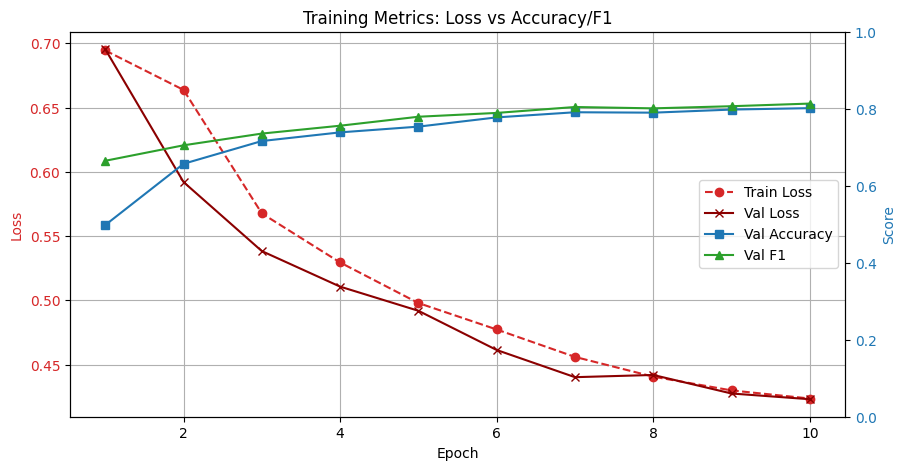

In [12]:
# Plotting both Loss and Accuracy
fig, ax1 = plt.subplots(figsize=(10, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Plot Loss on Left Y-Axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs_range, history['train_loss'], label='Train Loss', color='tab:red', linestyle='--', marker='o')
ax1.plot(epochs_range, history['val_loss'], label='Val Loss', color='darkred', linestyle='-', marker='x')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.grid(True)

# Create Right Y-Axis for Metrics
ax2 = ax1.twinx()
ax2.set_ylabel('Score', color='tab:blue')
ax2.plot(epochs_range, history['val_acc'], label='Val Accuracy', color='tab:blue', marker='s')
ax2.plot(epochs_range, history['val_f1'], label='Val F1', color='tab:green', marker='^')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_ylim(0, 1)

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

plt.title('Training Metrics: Loss vs Accuracy/F1')
plt.show()

In [13]:
def predict(model, image_name, caption, features_dir, tokenizer, device):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        str(caption), add_special_tokens=True, max_length=50, padding='max_length', truncation=True, return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding['token_type_ids'].to(device)
    
    base_name = image_name.split('.')[0]
    feature_path = os.path.join(features_dir, f'{base_name}.pt')
    
    try:
        features = torch.load(feature_path)
        visual_feats = features['visual_feats'].to(device).unsqueeze(0)
        visual_pos = features['visual_pos'].to(device).unsqueeze(0)
    except FileNotFoundError:
        print(f'Feature file not found for {image_name}')
        return None
    
    with torch.no_grad():
        logits = model(input_ids, visual_feats, visual_pos, attention_mask, token_type_ids)
        prob = torch.sigmoid(logits).item()
    return prob


--- Model Inference Demo (Validation Set) ---
Image: 2073964624.jpg
True Caption:  a woman wearing a pink cap riding a bicycle
Score (True Match): 0.8587
Score (False Match): 0.0061


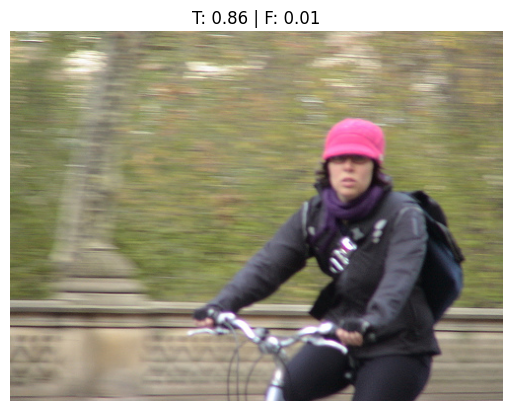

In [25]:
# Inference Demo
print('--- Model Inference Demo (Validation Set) ---')

# Get Random Sample from Validation Set
val_idx = random.choice(val_dataset.indices)
sample_row = full_dataset.data.iloc[val_idx]

test_img = sample_row['image_name']
true_caption = sample_row['comment']
false_caption = 'A group of flying aliens landing on the moon.'

print(f'Image: {test_img}')
print(f'True Caption: {true_caption}')

score_true = predict(model, test_img, true_caption, FEATURES_DIR, tokenizer, device)
score_false = predict(model, test_img, false_caption, FEATURES_DIR, tokenizer, device)

if score_true is not None and score_false is not None:
    print(f'Score (True Match): {score_true:.4f}')
    print(f'Score (False Match): {score_false:.4f}')

    img_path = os.path.join(IMAGE_DIR, test_img)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'T: {score_true:.2f} | F: {score_false:.2f}')
        plt.show()
    else:
        print(f"Image not found at {img_path}")
else:
    print("Could not run prediction (missing features?)")